La page ci-présente existe en version notebook téléchargeable grâce au bouton ![Bouton](./images/bouton_tl.png) (choisir le format `.ipynb`). On rappelle qu'l faut ensuite l'enregistrer dans un répertoire adéquat sur votre ordinateur (`capa_num` par exemple dans votre répertoire personnel) puis lancer Jupyter Notebook depuis Anaconda pour accéder au notebook, le modifier et exécutez les cellules de code adéquates.

# Etude de l'atmosphère terrestre

__But :__ étudier les variations de température et de pression dans l'atmosphère.

## Position du problème
### Modélisation de l'atmosphère
Dans le cadre du modèle ISA (International Standard Atmosphere), l'atmosphère est divisée en différentes couches, au sein desquelles la température est supposée suivre une [loi affine](https://fr.wikipedia.org/w/index.php?title=Atmosphère_normalisée&oldid=181118275). La valeur du gradient vertical de température dans chacune de ces couches est normalisée.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Pour l'affichage des données
"""Données normalisées pour chaque couche de l'atmosphère.
Vous pourrez utiliser ces vecteurs par la suite.
"""

couche = ["Troposphère", "Tropopause", "Stratosphère", "Stratosphère", "Stratopause", "Mesosphère", "Mesosphère", "Mesopause"]
altitude = [0, 11, 20, 32, 47, 51, 71, 85]
gradient = [- 6.5, 0, + 1.0, + 2.8, 0, - 2.8, - 2.0, "NA"]  # Attention il faudrait traiter le dernier élément qui n'est pas un nombre.

"""Affichage des données
La syntaxe utilisée n'est pas à connaître.
"""
datas = pd.DataFrame({
    "Couche atmosphérique" : couche,
    "Altitude de la base (km)" : altitude,
    "Gradient thermique vertical (K/km)" : ["{:.1f}".format(i)  if type(i)==float else i for i  in gradient]
})

datas.style

,Couche atmosphérique,Altitude de la base (km),Gradient thermique vertical (K/km)
0,Troposphère,0,-6.5
1,Tropopause,11,0
2,Stratosphère,20,1.0
3,Stratosphère,32,2.8
4,Stratopause,47,0
5,Mesosphère,51,-2.8
6,Mesosphère,71,-2.0
7,Mesopause,85,NA


On propose ici de déterminer numériquement la loi de variation de la pression atmosphérique avec l'altitude $z$ dans le cadre du modèle ISA, en supposant que l'atmosphère est __un gaz parfait au repos__ dans le référentiel terrestre galiléen et en négligeant les variations de la pesanteur avec l'altitude. On fixe les valeurs de la température et de la pression au niveau du sol (en z = 0) respectivement à :

$$
\begin{cases}
T_{sol} &= 288 K\\
P_{sol} &= 1.013 \times 10^5 Pa
\end{cases}
$$

On utilisera les données obtenues pour étudier les  mouvements d'un ballon sonde.

#### Données numériques
On prend :
\begin{align}
\textrm{Accélération de la pesanteur} &:& g = 9.81 m.s^{-2}\\
\textrm{Masse molaire de l'air} &:& M_{air} = 29 g.mol^{-1}\\
\textrm{Constante des gaz parfaits} &:& R = 8.314 J.K^{-1}.mol^{-1}
\end{align}

### Mise en équation
On dispose de deux fonctions à intégrer : $T(z)$ et $P(z)$ de deux équations : le modèle affine par morceaux de la température et l'équation de la statique des fluides appliquées à un gaz parfait. Il vient le système (on note le gradient $k_{ISA}$ de température) :

$$
\begin{cases}
\frac{\rm{d}T}{\rm{dz}}(z) &= k_{ISA}(z) \\
\frac{\rm{d}P}{\rm{dz}}(z) &= - {M_{air} g \over RT(z)} \times P(z)
\end{cases}
$$

avec 

$$
\begin{cases}
T(z = 0) &= T_{sol} \\
P(z = 0) &= P_{sol}
\end{cases}
$$

### Schéma d'Euler explicite
On utilise un schéma d'Euler explicite pour le vecteur :

$$Y(z) = \begin{cases}T(z) \\ P(z) \end{cases}$$

Pour un pas d'intégration $h$ et une suite de valeurs $Y_k$ aux altitudes $z_k$, on utilisera la relation de récurrence :

$$
Y_k{k+1} = Y_k + h \times F(z_k, Y_k)
$$

## Détermination du profil de pression et température

> __Exercice 1 :__  
> 1. Ecrire une fonction `kISA` qui prend comme argument une altitude `z` et qui renvoie le gradient de température $k_{ISA}(z)$ associé. Pensez à utiliser les listes définies au début.
> 2. Ecrire une fonction `F_atm(z, Y)` qui prend comme argument l'altitude `z` et le vecteur `Y`$=[T(z), P(z)]$ et qui renvoie la fonction `F` définie précédemment pour ces valeurs. _On rappelle que `F` doit être un __vecteur__._
> 3. Ecrire une fonction `euler(F, pas, Y0, zf)` qui implémente le schéma d'Euler explicite pour une fonction `F` avec un `pas` d'intégration, des conditions aux limites données par le vecteur `Y0`  en $z=0$ et l'altitude finale de l'intégration `zf`. Elle doit renvoyer un vecteur donnant les altitudes de calcul et un tableau à deux colonnes donnant les solutions $[T_k, P_k]$
> 4. Utiliser la fonction précédente pour obtenir le profil de température et de pression dans l'atmosphère pour le modèle ISA.
> 5. Tracer deux deux graphiques les profils $T(z)$ et $P(z)$.

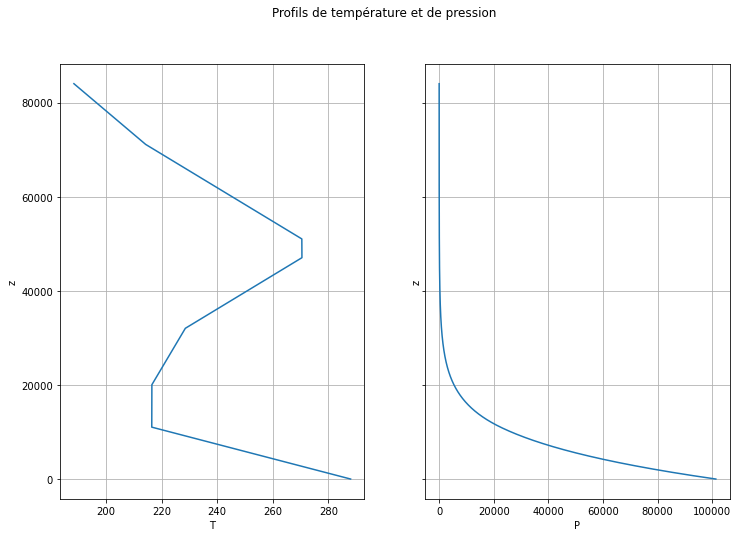

[0.42462264 0.42454557 0.42446852 0.42439148 0.42431445 0.42423744
 0.42416044 0.42408345 0.42400647 0.42392951]


In [45]:
from scipy.integrate import odeint
"""Les bibliothèques scientifiques ont déjà été importées"""
Mair = 0.029
g = 9.81
R = 8.314

def kISA(z):
    i=0
    while i<len(gradient) and z >= altitude[i]*1000:
        i = i +1
    return gradient[i-1]/1000

def F_atm(z,Y):
    return [kISA(z), -Mair * g / (R * Y[0]) * Y[1]]

zk = np.arange(0, 84000, 1)
sol = odeint(F_atm, [288., 1.013e5], zk, tfirst=True)
T_sol = sol[:,0]
P_sol = sol[:,1]

f, ax = plt.subplots(1,2, figsize=(12,8), sharey="row")
f.suptitle("Profils de température et de pression")
ax[0].set_xlabel("T")
ax[0].set_ylabel("z")
ax[1].set_xlabel("P")
ax[1].set_ylabel("z")

ax[0].plot(T_sol, zk)
ax[1].plot(P_sol, zk)
ax[0].grid()
ax[1].grid()
plt.show()
print(P_sol[-10:])

> __Exercice 2 :__  
> 1. Reprendre l'exercice précédent mais en utilisant la fonction `odeint` dela bibliothèque `scipy.integrate`

_Indications utiles_ : 
* Pour pouvoir réutiliser la fonction `F_atm`, pensez à ajouter l'argument `tfirst=True` dans la fonction `odeint`.

In [55]:
from scipy.integrate import odeint


## Dimensionnement d'un ballon-sonde atmosphérique
Les ballons-sonde stratosphériques constituent une solution simple et relativement économique pour envoyer une charge dans l'atmosphère. Équipés de capteurs divers, ils peuvent par exemple permettre de relever les valeurs de la pression, de la température, de l'humidité ou encore devitesse du vent dans les différentes couches de l'atmosphère traversées

### Position du problème

On considère ici un ballon-sonde stratosphérique "ouvert", constitué d'une enveloppe de volume $V$ ouverte sur l'extérieur par des manches d'évacuation situées à la base du ballon. Au moment du lancement, le ballon est gonflé à l'hélium ($M_{He} = 4,0 g.mol^{-1}$) ; l'enveloppe garde un volume constant tout au long de l'ascension. Le ballon étant ouvert à sa base, la pression à l'intérieur du ballon est identique à tout moment à la pression atmosphérique. La masse de l'ensemble { enveloppe (hors hélium) + nacelle + instruments embarqués } est $m = 10 kg$.

> __Exercice 2 :__
> On souhaite que le ballon atteigne une altitude $z_{max}$ choisie.
> 1. Estimer le volume $V$ de l'enveloppe qui permet d'atteindre cette altitude puis le diamètre du ballon associé.
> Vous devrez :
> * Préciser la modélisation et le paramétrage du problème. On discutera notamment des hypothèses choisies.
> * Tracer V et d en fonction de$z_{max}$.
> * Estimer V et d pour $z_{max} = 36 km$ en procédant par dichotomie pour trouver l'indice donnant l'altitude la plus proche de $z_{max}$. Commenter la possibilité pour des amateurs de réaliser un tel ballon.

## Complément
> __Exercice 3 :__  
> Si le temps le permet, reprendre l'intégration du système mais en tenant compte des variation du champ de pesanteur avec l'altitude en assimilant ce dernier au champ de gravitation terrestre.  
> Vous représenterez les champs de pression pour les deux modèles (champ de pesanteur uniforme et non uniforme) ainsi que le tracé de l'écart relatif entre les deux modèles en fonction de l'altitude.